In [83]:
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib import colors as mclr
import os 
import pickle

In [84]:
plt.rc('font', family = 'Times New Roman')
plt.rc('font', size = 14)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=18)
plt.rc('lines', linewidth=2.5)

In [85]:
figDirectory = "../figures/"

In [86]:
from demler_tools.file_manager import path_management, io

In [87]:
path_management.initialize(project_name = 'xy_qmc')

Successfully initialized path management with following parameters:
     username:                jcurtis
     project name:            xy_qmc
     controlling machine:     workstation
     library version:         v2.3.0-beta-1-g7645a25
     auto SSH transfer:       True
     default save location:   /scratch/savefiles
     LTS mount point:         /home
     email domain:            phys.ethz.ch
     cluster OS:              Ubuntu
     cluster partition:       work
     SSH host file:           /home/jcurtis/.ssh/known_hosts
     SSH key file:            /home/jcurtis/.ssh/id_ed25519_euler
     default modules:         {'CentOS': 'gcc/8.2.0 python/3.11.2', 'Ubuntu': 'stack/2024-06 python/3.11.6'}


In [88]:
timestamp = '1758283897'

print( io.get_results(timestamp = timestamp,run_index=0) )

({'M': 8, 'Ej': 1.0, 'Ec': 0.2, 'L': 10, 'dt': 0.03, 'nburn': 10000000, 'nsample': 30, 'nstep': 1000000, 'over_relax': True, 'save_filename': '/scratch/savefiles/xy_qmc/simulation_results/1758283897/sr_0'}, (array([-133019.60833299, -132974.46895003, -133005.40914646,
       -132966.08006338, -132990.96512559, -132961.27380586,
       -132994.92638789, -132981.22129298, -133022.51042773,
       -132970.8387361 , -132979.67095281, -133016.17159534,
       -132987.8039088 , -132989.55826449, -132989.96194789,
       -133001.65005607, -133029.77399413, -133002.38814206,
       -133010.15266355, -132981.26264425, -133004.75632671,
       -132970.80827719, -132994.25093517, -133033.43230142,
       -133001.64339462, -132971.83767236, -132970.37112236,
       -132962.44593952, -133006.40235581, -132979.76014371]), array([-0.0722305 -7.11204734e-02j,  0.18034966+1.02751842e-01j,
       -0.22949203+1.93746374e-01j, -0.07649421-7.43549146e-02j,
        0.01374951-9.72524574e-02j, -0.13501052-8.

In [89]:
job_no = io.recover_job_no(timestamp = timestamp)

dt:  0.03
M:  8
T:  4.166666666666667


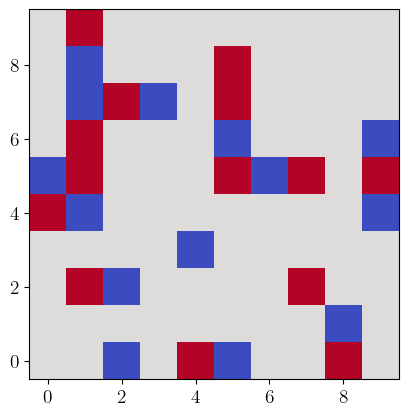

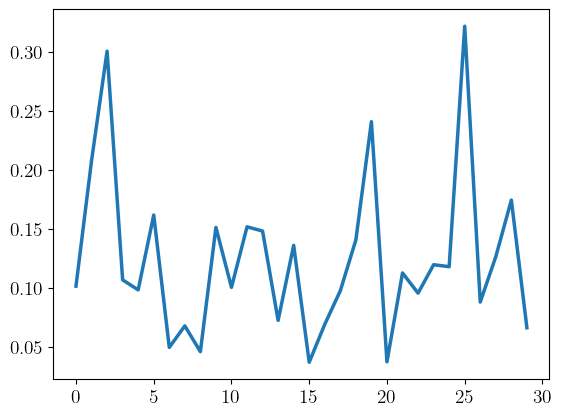

dt:  0.03
M:  12
T:  2.7777777777777777


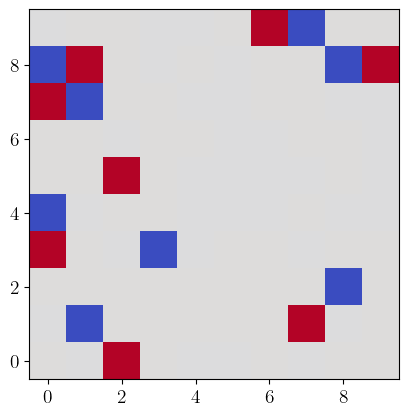

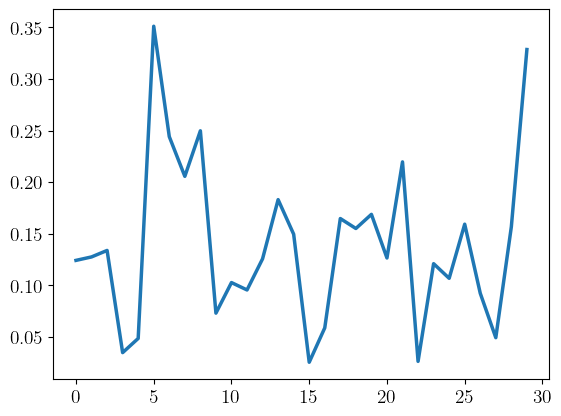

dt:  0.03
M:  16
T:  2.0833333333333335


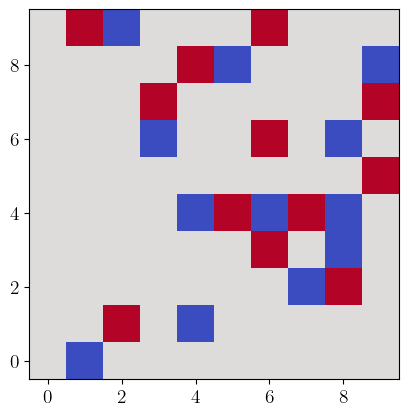

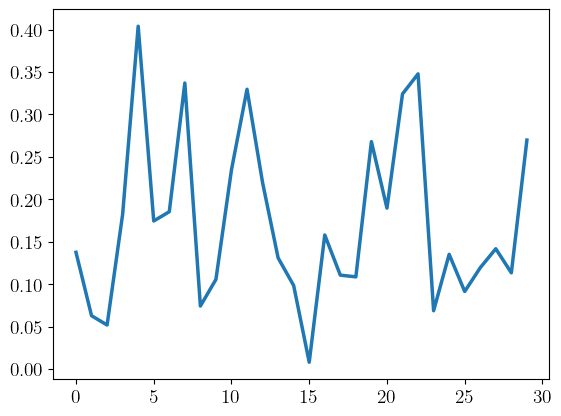

dt:  0.03
M:  24
T:  1.3888888888888888


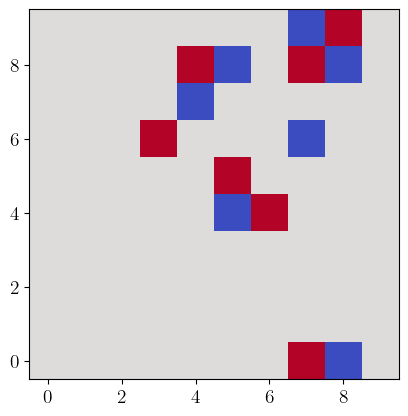

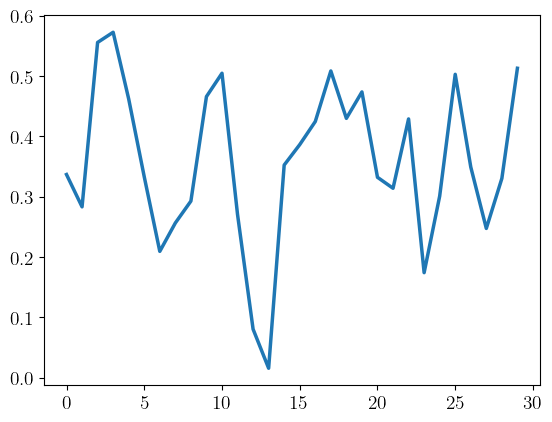

In [90]:
for job in range(job_no):
    inputs, data = io.get_results(timestamp = timestamp,run_index = job)
    actions,OPs,vorts,angles = data
    print("dt: ",str(inputs['dt']) )
    print("M: ",str(inputs['M']))
    print("T: ",str(1./(inputs['dt']*inputs['M'])))
    
    plt.imshow(np.transpose(vorts[:,:,0,-1]),origin='lower',cmap='coolwarm',norm=mclr.Normalize(-2.*np.pi,2.*np.pi) )
    plt.show()
    plt.plot(np.abs(OPs))
    plt.show()

In [49]:
timestamp = '1753958771'

In [50]:
job_no = io.recover_job_no(timestamp = timestamp)

In [46]:
shifts = np.array([0,4,8,12,16,20,30,40,50])
temps = np.zeros(job_no)
nshifts = len(shifts)
autocorrelation = np.zeros((job_no,nshifts))

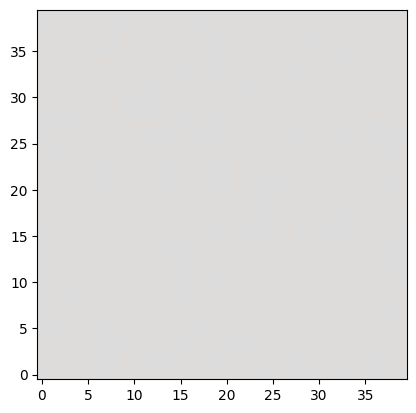

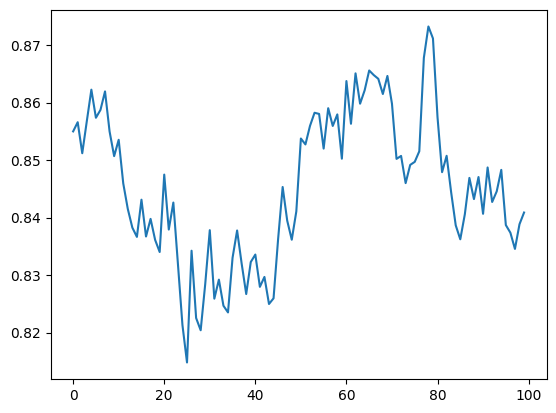

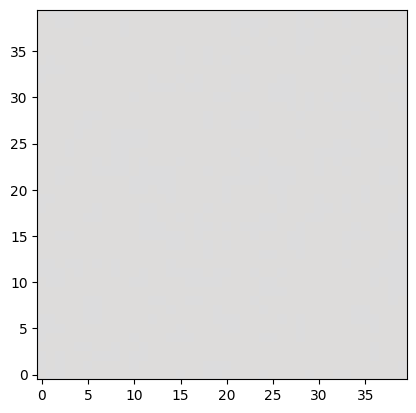

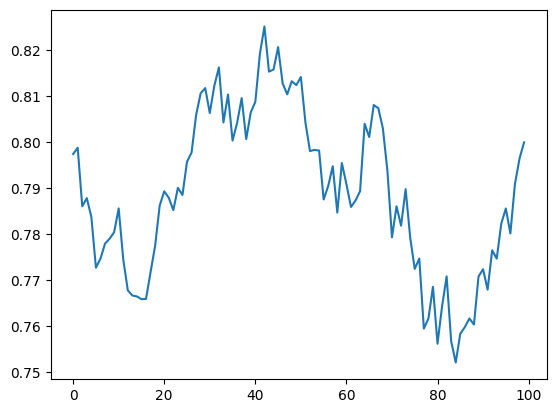

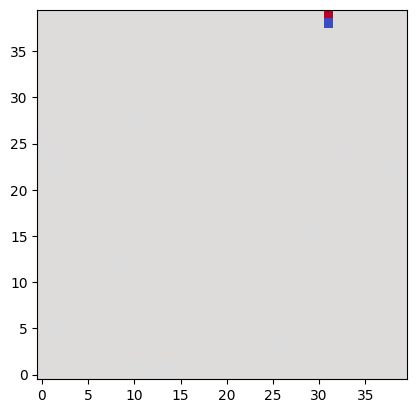

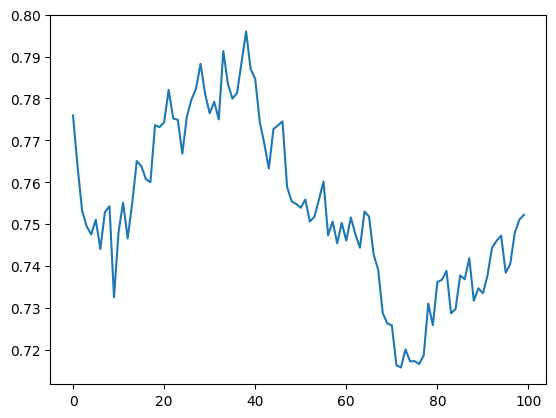

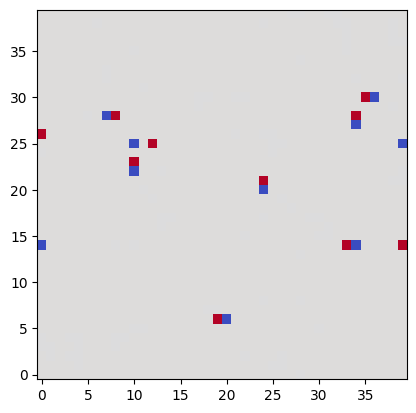

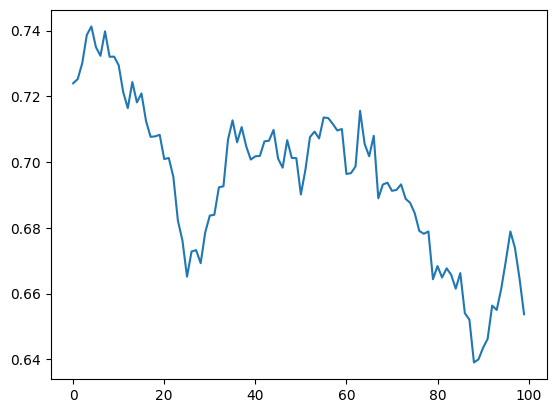

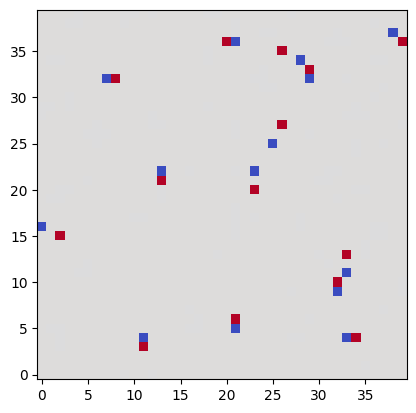

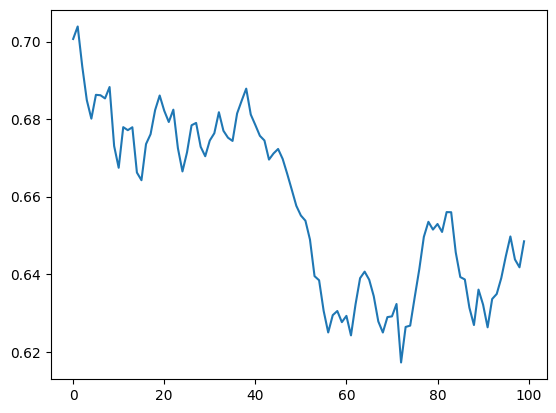

IndexError: index 5 is out of bounds for axis 0 with size 5

In [51]:
for job in range(job_no):
    inputs, data = io.get_results(timestamp = timestamp,run_index = job)
    temps[job] = inputs['T']
    actions,OPs,vorts,angles = data

    #for i in range(nshifts):
    #    autocorrelation[job,i] = autocorrelator(OPs,shifts[i])

    plt.imshow(np.transpose(vorts[:,:,0,-1]),origin='lower',cmap='coolwarm',norm=mclr.Normalize(-2.*np.pi,2.*np.pi) )
    plt.show()
    plt.plot(np.abs(OPs))
    plt.show()

{'T': 0.8947368421052632, 'Ej': 1.0, 'Ec': 0.05, 'L': 40, 'M': 10, 'nburn': 500000, 'nsample': 100, 'nstep': 10000, 'over_relax': True, 'save_filename': '/scratch/savefiles/xy_qmc/simulation_results/1753958771/sr_3'}


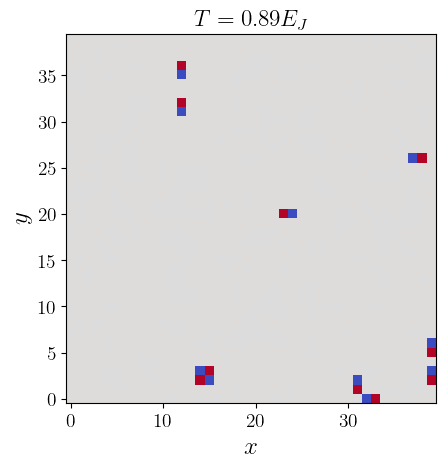

In [79]:
job = 3

inputs, data = io.get_results(timestamp = timestamp,run_index = job)
actions,OPs,vorts,angles = data
print(inputs)
plt.imshow(np.transpose(vorts[:,:,0,-31]/(2.*np.pi)),origin='lower',cmap='coolwarm',norm=mclr.Normalize(-1.,1.) )
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$T=0.89 E_J$')
#plt.savefig(figDirectory+'/vortex_example.pdf',bbox_inches='tight')
plt.show()

In [46]:
def autocorrelator(OPsamples,shift):
    ### we compute the autocorrelation function of the OP samples to see how well the overrelaxation works
    OPs_rolled = np.roll(OPsamples,shift=shift)
    return np.abs(np.mean(np.conjugate(OPs_rolled)*OPs)-np.abs(np.mean(OPs))**2)

    

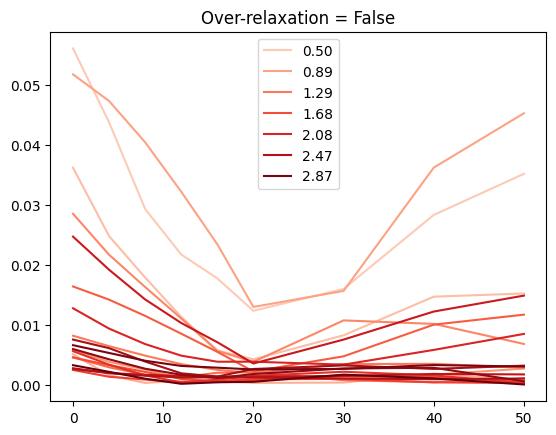

In [58]:
from matplotlib import cm
clrs = cm.Reds(np.linspace(0.2,1.,job_no))
for job in range(job_no):
    if job % 3 == 0:
        plt.plot(shifts,autocorrelation[job,:],color=clrs[job],label="{t:0.2f}".format(t=temps[job]))
    else:
        plt.plot(shifts,autocorrelation[job,:],color=clrs[job])

plt.title(r'Over-relaxation = False')
plt.legend()
plt.show()

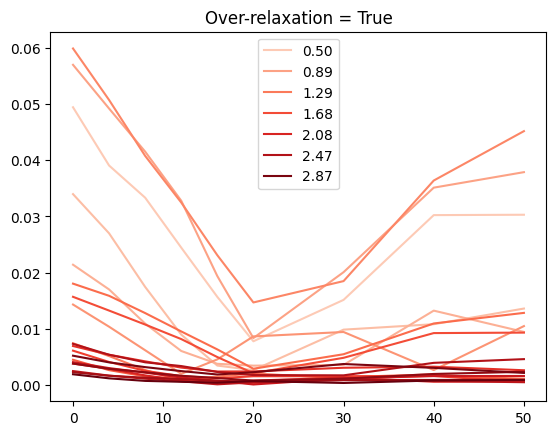

In [52]:
from matplotlib import cm
clrs = cm.Reds(np.linspace(0.2,1.,job_no))
for job in range(job_no):
    if job % 3 == 0:
        plt.plot(shifts,autocorrelation[job,:],color=clrs[job],label="{t:0.2f}".format(t=temps[job]))
    else:
        plt.plot(shifts,autocorrelation[job,:],color=clrs[job])

plt.title(r'Over-relaxation = True')
plt.legend()
plt.show()